## DQN on the CartPole problem

### The CartPole problem

As the image below shows, the goal of the agent is to balance a verticle rod on the top of the car. This position is unstable and that is the main reason for the difficulty.

<img src="https://drive.google.com/uc?export=download&id=1wiFksyB3-mcirfdZEvrT2DPD7SBEjye2" >

The problem is solved if the average of the agent's scores is greater than 195 gathered in 100 episodes.
The agent receives reward 1 in each timestep until the psoition of the rod is correct (not inclined too far away from the vertical position).
The length of one episode is 200 time steps. Therefore the possible maximum score is 200.

The state is low dimensional and cosists of:
* position 
* velocity
* angle 
* angular velocity

Further details can be found on OpenAI gym's webpage: [Leader Board](https://github.com/openai/gym/wiki/CartPole-v0)

In [1]:
# Lets mount the Google Drive , which can be used to save data and read saved output for plotting
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline
%tensorflow_version 1.x
import matplotlib.pyplot as plt
import gym 
from gym.wrappers import Monitor
import numpy as np
import random
from enum import Enum
from skimage import transform as trf
from keras.models import Sequential # Keras: highlevel API above dnn libraries (tendorflow, cntr, theano)
from keras.layers import Dense, Convolution2D, Flatten
from keras.optimizers import Adam, SGD, RMSprop

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
# lets first understand what the environment is returning and doing
import gym 
from gym.wrappers import Monitor
env = gym.make('CartPole-v0')

env.reset()
env.step(0)

(array([-0.00753988, -0.23413647,  0.04625965,  0.2739581 ]), 1.0, False, {})

### Environment
env.step returns 4 variables:
1. As explained earlier the cartpole has four features which represent its state this is represented by an array of 4 values (position,velocity, angle, angular velocity)
2.  next is reward, 
3. and the third variable tells whether it’s time to reset the environment again (case being perhaps the pole tipped too far, or you lost your last life.)
4. diagnostic information useful for debugging( not to be used in general)

https://gym.openai.com/docs/#environments

In [ ]:
# There are two action only but lets still explore what is action space
print("Total actions",env.action_space)

# Lets explore the observation space (state) i.e 4 features which describe the state
# note the termination condition has x(position) > 2.4 or x < -2.4, however the bound of x if [-4.8,4.8]
print("obersavation space high-bound",env.observation_space.high)
print("obersavation space low-bound",env.observation_space.low)

Total actions Discrete(2)
obersavation space high-bound [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
obersavation space low-bound [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


In [3]:
class Optimizer(Enum): # Enum, Makes easier to try different optimizers
    ADAM = 1
    RMSPROP = 2
    SGD = 3

### Background: 

In the reinforcement learning problem, the agent observes the current state and takes action, now based on action taken and the environment dynamics the environment moves to different state( next state). The agent then observes this state and again takes action, this process continues till the terminal condition is reached.

sequence(S) - x(t), a(t), x(t+1), a(t+1).....x(T).
As can be seen this gives rise to very long MDP and we can apply RL to solve for optimal policy. The point to be noted here is that agent still doesnt know how the environments internal dynamics works, and had to come-up with optimal policy. In the most RL problems like the one here, the agent interacts with the emulator (mimics environment), gets obervation, takes action, gets reward and next state and process continues. One way to solve this problem is using optimal action-value function. If we know the Q-function which gives action-value for all action in state 's' then we can get the optimal policy by taking action which maximizes the expected return. Further to achieve this, we use the functional approximator which can give the Q-value, taking the input as (state,action) pair. We have used the radial basis function in mountain-car as approximator, while here we are using Deep-network instead to do this work of function approximation (called Q-network).

In DQN (Deep Q-network), as we know there has to be some target value and prediction, we calculate the loss between these two and using Gradient descent we update the weights on Q-network to minimize this loss for an iteration ( as represented by the equation below).

$$\theta_{t+1} = \theta_t + \alpha \cdot \left( r_t + \max_{a'}Q_\theta(s', a') - Q_\theta(s, a) \right)\cdot \nabla_\theta Q_\theta(s, a)|_{\theta = \theta_t}
$$


This approach is both:
1. Model Free: As agent learns or solves the task ny using the samples from emulator.
2. Off-Policy: It learns the target policy while following the behavioural distribution (with adequate exploration).

What is the difference in DQN from Online Q-Learning (or continous Q-Learning)?
In the Online Q -Learning,  there is fast changing (high variance) of the one-step return. The one-step return depends on the network itself and the network weight are updated frequently, this makes the Q-network instable. DQN overcomes this by using Experience Replay and Iterative update.


Ref: [DQN](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)
    [Double Q-Network](https://arxiv.org/pdf/1509.06461.pdf)



1. What is experience for the cartpole or any RL problem:
As highligted in the image the experience is a tuple of (current state, action, reward, next state), we can add the last element as boolean flag to tell if need to reset env or not.
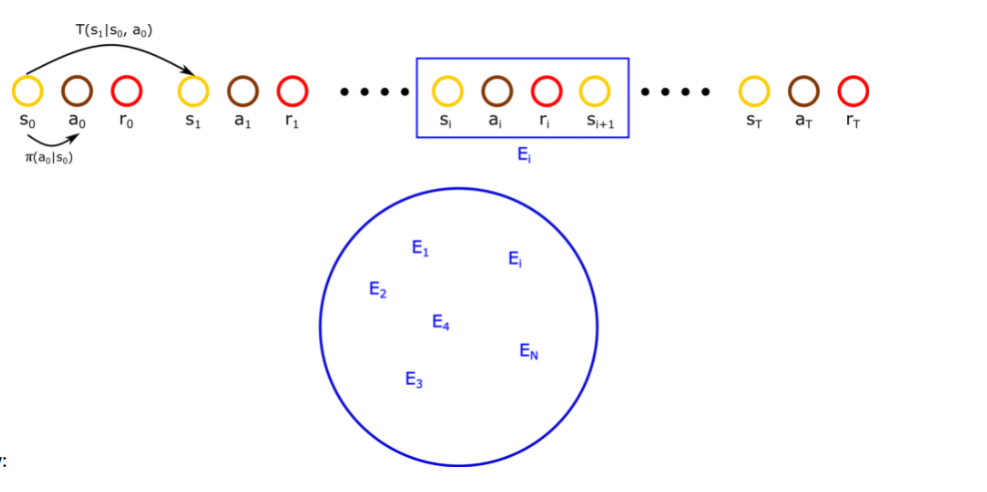


2. In iterative update there are two networks (target and online Q-Leanring) for representing the  Q -function. The architecture is the same but the weights are different. The target network,
with parameters θ**, is the same as the online network except that its parameters are copied every τ steps from the
online network, so that then θ(t) **= θ(t), and kept fixed on all
other steps.

In the standard Q-learning and DQN the same weights are used to select and evaluate the action i.e target (represented below)
$$ y_t = r_t + \gamma\max_{a'}Q_\theta(s', a')$$

However we can de-couple the selection and estimation part, where the selection of action comes from $Q_{\phi_{1}}$ and evaluation from $Q_{\phi_{2}}$. This is called Double Q-Learning network.

$$y_{t}=r_{t}+\gamma Q_{\phi_{2}}\left(s_{t}^{\prime}, \operatorname{argmax}_{a^{\prime}} Q_{\phi_{1}}\left(s^{\prime}, a^{\prime}\right)\right)$$



### Episode Termination Condition:

1.Pole Angle is more than ±12°

2.Cart Position is more than ±2.4 (center of the cart reaches the edge of the display)

3.Episode length is greater than 200 (500 for v1).

In the code below there is if loop as provided below, which deals with **credit assignment**, if the last action lead to (failed) termination then we make reward -1, else we give reward = 100 (successful termination)


    if done:
      print("Termination condition")
      if rtn < 180:
          print("bad", rtn)
          rw = -1
          obs_next *= 0.0
          obs *= 0.0
      elif rtn >= 180:
          print("Good", rtn)
          rw = 100 

Sampling:

In the code below, during the training, experiences set is build by selecting the action as per the Online Q-network ( q_cont), while the target Q-value is estimated using the Target network ( q_frzn ). This technique makes this double q- network rather a standard deep q-network. However it is also pointed that there are other variants also where we can choose the selection and estimation to be done by network through coin flip (0.5 probability to select either of Q-network for 'selection' process and other one for 'estimation'). Further the target is

$$ y_t  = { r_t \hspace{0.2cm} for \hspace{0.2cm} terminal \\ 
= rt + γ \operatorname{max}_{a^{\prime}} Q(φ_{t+1}, a\prime
; θ) for \hspace{0.2cm} non-terminal} $$

(this is incorporated using (1-dones) in the code below)

In [4]:
# importing some other libraries we will need
from numpy.random import seed
import tensorflow as tf
from tensorflow.keras import backend as be
import pickle
import pandas as pd

be.clear_session()
tf.compat.v1.reset_default_graph()

In [5]:
# The implementation of DQN.
class Dqn:

    
    def __init__(self, params):         
        self.env = None                       # The environment where the RL agent will learn.
        self.buffer_size = params.buf_size    # The maximum size of the experience replay.
        self.batch_size = params.batch        # Batch size during training.
        self.epoch = params.epoch             # For one training cycle, the number epoch on a batch.
        self.max_episode = params.max_ep      # The number of episodes for training.
        self.eps0 = params.eps                # The starting value of epsilon in the epsilon-greedy policy.
        self.gamma = params.gamma             # Discounting factor.
        self.C = params.C                     # Frequency of synchronizing the frozen network.
        self.train_freq = params.train_freq   # Update frequency for the not frozen network.
        self.eval_freq = params.eval_freq     # Evaluation frequency.
        self.net = params.net                 # The description of the network. List of tuples. A tuple: (number of units, activation)
        self.lr = params.lr                   # learning rate
        self.opt = params.opt                 # Optimizer.

        self.q_cont, self.q_frzn = None, None # two networks for training: continuously updated and frozen

        self.buffer = []  # experience replay
    
        self.env = gym.make('CartPole-v0')
        self.env.reset()
        self.q_cont, self.q_frzn = self._init_models()

        #----------------------------------Added parameter----------
        # param to check if to print buffer or not
        self.check_buffer = params.check_buffer
        # # param to initialize the buffer with these number of experiences,
        # if None then buffer gets initialized with batch size
        self.init_buffer_size = params.init_buffer_size
    
    # ------------------------------------------------------
    # functions for initialization
    
    def _init_optimizer(self):

        optz = None
        if self.opt == Optimizer.ADAM:
            optz = Adam(self.lr)
        elif self.opt == Optimizer.SGD:
            optz = SGD(self.lr)
        elif self.opt == Optimizer.RMSPROP:
            optz = RMSprop(self.lr)

        return optz

    # The network builds up from Dense layers (similar to the fully connected)
    def _init_models(self):
        
        def build(strc):
            # strc - list of tuples
            # each tuple contains: number of nodes in the dense layer, activation function name (e.g.: 'relu')

            q = Sequential() 

            # NOTE 1. The input shape = (4,) is for the dimension of state space which has four variables as discussed above, alternatively 
            # there could be image (box) as the input also in which case there is practice to stack few frames (ex 4 frames) 
            # whereby then Conv2D filter can be applied to allow the netowrk to extract the feature on its own, rather than hand-crafting
            # features.
          
            q.add(Dense(strc[0][0], activation=strc[0][1], input_shape=(4,)))
            
            # adding the the remaining dense layers to the model.
            for i in range(1, len(strc)):
                q.add(Dense(strc[i][0], activation= strc[i][1]))

            optz = self._init_optimizer()
            q.compile(optimizer=optz, loss = 'mse')

            return q

        q_cont = build(self.net)  # continuously updated network (Q-function)
        q_frzn = build(self.net)  # frozen network (target)

        q_cont.set_weights(q_frzn.get_weights())  # initial synchronization

        return q_cont, q_frzn

    def _init_buffer(self, number):
        # gathers 'number' pieces of experiences randomly
        exps = []
        obs, rw, done, _ = self.env.step(0)
        
        for _ in range(number):

            if done:
                obs = self.env.reset()

            action = self.env.action_space.sample()  # sampling random actions from the environment
            obs_next, rw, done, _ = self.env.step(action)  # taking the step and observe the results
            exps.append((obs, rw, action, done, obs_next))  # we append a new experience
            obs = obs_next

        self.append(exps)  
    
    def close(self):
        self.env.close()

    def train_function(self):
        
        # initializing experience replay with random experiences
        # this is implemented if we want ot initialize the buffer with 
        # number of experiences other than batch size
        if not self.init_buffer_size:
          self._init_buffer(self.batch_size)
        else:
          self._init_buffer(self.init_buffer_size)

        print("Initialization was finished.")
        print("Training was started.")
        train_t = 1
        ep_id = 1
        cntr = 0
        eval_permitted = True
        rtn = 0
        exps = []
        
        ep_ids = []
        returns = []

        eps = self.eps0
        self.env.reset()

        # initialization
        obs, _, done, _ = self.env.step(0)
        
        # check condition for max_episodes to run during training
        while ep_id < self.max_episode:

            # print("cache experience replay size",len(exps))
            # print("Counter",cntr,'\n', "Return", rtn)

            # Note 2.
            # Each episode has a sequence of (state,action,reward,nextstate), counter
            # keeps the track of same. We will use the same to trigger the training and 
            # appending the set of experiences collected (cachce) to the buffer (experience replay buffer). 
            cntr += 1
            
            # Note 4. check condition to see if we need to reset the environment, update the episode id and reset rtn = 0.
            if done:
                # print("episode id", ep_id, " & Return is", rtn)

                if ep_id % 10 == 0:
                    print('Episode Id: ' + str(ep_id) + ' Return during training: ' + str(rtn))
                rtn = 0
                ep_id += 1
                eval_permitted = True
                obs = self.env.reset() # when an episode ends (done = True) the environment is reseted

            # Note 5.we select next action with epsilon greedy approach using q_cont (in select_action_epsilon function)
            action = self.select_action_epsilon(obs, eps)  # ---- select the next action with epsilon greedy -----

            obs_next, rw, done, _ = self.env.step(action)  # ----- take a new step with the environment -----
            rtn += rw
            
            # Note 3.
            # If the experience leads to termination then it could be either we failed ( angle > 15, x > 2.4, x< -2.4 etc)
            # or we succesfully completed the game. In each case we do the credit assignment. if return > 180 then its good else bad and
            # therefore we appropriately update reward.
            if done:
                # print("Termination condition")
                if rtn < 180:
                    # print("bad", rtn)
                    rw = -1
                    obs_next *= 0.0
                    obs *= 0.0
                elif rtn >= 180:
                    # print("Good", rtn)
                    rw = 100

            exps.append((obs, rw, action, done, obs_next))
            obs = obs_next

            # Note 6. This is to append the experiences cache to buffer (expereince replay), and clear the cache of 
            # experiences set
            if cntr % 128 == 0:
                self.append(exps)
                exps.clear()
            
            # training
            # Condition to check if to trigger the training or not as defualt train_freq is '1', therefore for each iteration (counter) the training is triggered.
            if  cntr % self.train_freq == 0:
                # print('Trianing',train_t)
                train_t += 1

                # Note 7. for how the x(=a) and y (=b) are being processed we will need to look at sample function.( provided below) ##########################
                a,b = self.sample(self.batch_size)
                
                # Note 8. Q_cont is online Q-network which is trained regularly
                self.q_cont.fit(a,b,batch_size = self.batch_size, epochs = self.epoch, verbose = False)
                # ----- sample experiences from the replay then train q_cont with them
            
            # synchronizing the frozen network
            if cntr % self.C == 0:
                self.q_frzn.set_weights(self.q_cont.get_weights())

            # evaluating at the current stage of learning
            if ep_id % self.eval_freq == 0 and eval_permitted:

                # Note 9. r is mean return over 100 episodes (evaluation function had 50 episodes, but updated to 100 as per the problem description)
                r = self.evaluation()
                ep_ids.append(ep_id)
                returns.append(r)
                # reset the eval_permitted, this will become true again when, next episode is completed
                eval_permitted = False

                # Note 10. The problem is solved if average reward is 195 gathered in 100 episodes, 
                # https://github.com/openai/gym/wiki/Leaderboard#cartpole-v0

                if r >= 195:
                    break
            
            # Decreasing the epsilon value for epsilon-greedy. Exploration -> exploitation
            eps = max(eps - 0.001, 0.01)

        print("Training was finished.")
        return ep_ids, returns

    def evaluation(self, video=False):
        
        orig_env = self.env
        if video:
            self.env = Monitor(orig_env, 'videos/cartpole', force=True)

        obs = self.env.reset()
        done = False
        rtn = 0
        ep_id = 0
        rtns = []
        
        # Note. 11. updating the loop to account for 100 episodes
        while ep_id < 100:

            if done:
                rtns.append(rtn)
                rtn = 0
                ep_id += 1
                obs = self.env.reset()

            # As this is evaluation we can use epsilon-greedy with epsilon = 0.01
            action = self.select_action_epsilon(obs, 0.01)
            obs, rw, done, _ = self.env.step(action)
            rtn += rw

        self.env = orig_env
        return np.mean(rtns)

    # ------------------------------------------------------
    # Functions for handling the experience replay

    def clear_buffer(self):
        self.buffer.clear()

    # The new experiences are added at the end of the buffer.
    # The too old experiences are deleted.
    def append(self, experiences):
        check = self.check_buffer
        # experiences - list of experiences
        
        # ----- checking if appending the new set of experiences to the buffer has enough space -----
        if check:
          print("Buffer size is: ", len(self.buffer))
      

        if self.buffer_size - len(self.buffer) < len(experiences) :

            # deleting enteries in buffer from front (first in first out) for adding new experiences
            self.buffer = self.buffer[len(experiences)- (self.buffer_size - len(self.buffer)):]
            

        self.buffer += experiences  # finally we append the new experiences to the buffer

    def sample(self, number):
        exps = random.sample(self.buffer, number)    # experiences list
        obs = np.stack([x[0] for x in exps], axis=0) # numpy array is used by keras, for creating a batch observations should be stacked
        rws = np.stack([x[1] for x in exps], axis=0) # ----- do similar stacking for the rewards -----
        acts = np.stack([x[2] for x in exps], axis=0) # stacking of actions
        dones = np.stack([x[3] for x in exps], axis=0) # stacking of done (boolean)
        next_obs = np.stack([x[4] for x in exps], axis=0) # stacking of next state


        q_vals = self.q_cont.predict(obs) # ----- predict (forward execute) with q_cont on obs -----   # q_vals size should be: (batch_size, 2)
        fzn_q_vals = self.q_frzn.predict(next_obs) # ----- predict with q_frzn on next_obs -----
        

        # Note 12.
        # As explained above since q_cont has been used for action we use the q_frzn for q-val estimation
        # further (1-dones) is incorporated to factor in terminal condition
        sub_values = rws + self.gamma * (1 - dones) * np.max(fzn_q_vals, axis=1) # 
        # print("list",list(range(number)),"actions", acts)
        # print(q_vals[list(range(number)),acts] )
        # creating the list of target values for network
        q_vals[list(range(number)), acts] = sub_values  # this will be the target during training

        x = obs.astype(dtype=np.float32)
        y = q_vals.astype(dtype=np.float32)
        
        return x, y

    # ------------------------------------------------------
    # Choosing an action

    # epsilon-greedy
    def select_action_epsilon(self, state, eps):  # state shape: (4) nunmpy array
        s = np.expand_dims(state, axis=0)
        max_idx = np.argmax(self.q_cont.predict(s, batch_size=1))
        if np.random.random() < 1 - eps:
            return max_idx
        return (max_idx + 1) % 2 # now we have only two actions

    # no epsilon-greedy
    def select_action(self, state):
        s = np.expand_dims(state, axis=0)
        return np.argmax(self.q_cont.predict(s, batch_size=1))

In [6]:
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM
        # param to check if to print buffer or not
        self.check_buffer = False
        # param to initialize the buffer with these number of experiences,
        # if None then buffer gets initialized with batch size
        self.init_buffer_size = None

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initialization was finished.
Training was started.

Episode Id: 10 Return during training: 12.0
Episode Id: 20 Return during training: 9.0
Episode Id: 30 Return during training: 10.0
Episode Id: 40 Return during training: 11.0
Episode Id: 50 Return during training: 9.0
Episode Id: 60 Return during training: 10.0
Episode Id: 70 Return during training: 45.0
Episode Id: 80 Return during training: 125.0
Episode Id: 90 Return during training: 172.0
Episode Id: 100 Return during training: 148.0
Episode Id: 110 Return during training: 22.0
Episode Id: 120 Return during training: 200.0
Episode Id: 130 Return during training: 135.0
Episode Id: 140 Return during training: 141.0
Episode Id: 150 Return during training: 193.0
Episode Id: 160 Return during training: 65.0
Training was finished.


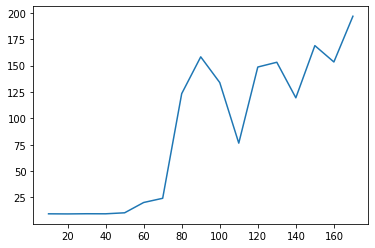

In [ ]:
# Running the training and evaluation with default set of params
from numpy.random import seed
seed(7)
tf.compat.v1.set_random_seed(7)

pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

As can be seen from graph the overall trend is upward and therefore it is able to converge, but to check what could be causing this apart from more and training being done, we can print buffer size at episodes and see if this is also a cause for same.

Buffer size is:  0
Initialization was finished.
Training was started.
Buffer size is:  256
Episode Id: 10 Return during training: 14.0
Buffer size is:  384
Episode Id: 20 Return during training: 12.0
Buffer size is:  512
Episode Id: 30 Return during training: 12.0
Episode Id: 40 Return during training: 10.0
Buffer size is:  640
Episode Id: 50 Return during training: 11.0
Buffer size is:  768
Buffer size is:  896
Episode Id: 60 Return during training: 13.0
Buffer size is:  1024
Buffer size is:  1152
Buffer size is:  1280
Buffer size is:  1408
Episode Id: 70 Return during training: 39.0
Buffer size is:  1536
Buffer size is:  1664
Buffer size is:  1792
Buffer size is:  1920
Buffer size is:  2048
Buffer size is:  2176
Buffer size is:  2304
Buffer size is:  2432
Buffer size is:  2560
Buffer size is:  2688
Episode Id: 80 Return during training: 182.0
Buffer size is:  2816
Buffer size is:  2944
Buffer size is:  3072
Buffer size is:  3200
Buffer size is:  3328
Buffer size is:  3456
Buffer size

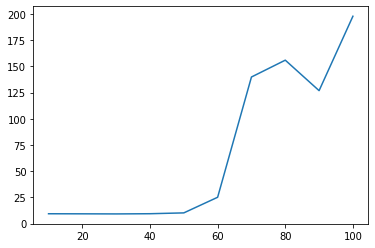

In [ ]:
# Running the training and evaluation with default set of params another run
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

        # param to check if to print buffer or not
        self.check_buffer = True

        # param to initialize the buffer with these number of experiences,
        # if None then buffer gets initialized with batch size
        self.init_buffer_size = None




be.clear_session()
tf.compat.v1.reset_default_graph()
seed(7)
tf.compat.v1.set_random_seed(7)

pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

As can be seen after the initial round of training and once the experience replay buffer is suffuciently large enough ( > 1000 experiences) we see the model improving rapidly. Therefore in next run lets initialize the buffer of size 1000 experiences rather than batch_size.

Buffer size is:  0
Initialization was finished.
Training was started.
Buffer size is:  1000
Episode Id: 10 Return during training: 21.0
Buffer size is:  1128
Buffer size is:  1256
Episode Id: 20 Return during training: 15.0
Buffer size is:  1384
Buffer size is:  1512
Episode Id: 30 Return during training: 96.0
Buffer size is:  1640
Buffer size is:  1768
Buffer size is:  1896
Buffer size is:  2024
Buffer size is:  2152
Buffer size is:  2280
Buffer size is:  2408
Buffer size is:  2536
Buffer size is:  2664
Episode Id: 40 Return during training: 109.0
Buffer size is:  2792
Buffer size is:  2920
Buffer size is:  3048
Buffer size is:  3176
Buffer size is:  3304
Buffer size is:  3432
Buffer size is:  3560
Buffer size is:  3688
Buffer size is:  3816
Buffer size is:  3944
Episode Id: 50 Return during training: 139.0
Buffer size is:  4072
Buffer size is:  4200
Buffer size is:  4328
Buffer size is:  4456
Buffer size is:  4584
Buffer size is:  4712
Buffer size is:  4840
Buffer size is:  4968
Buff

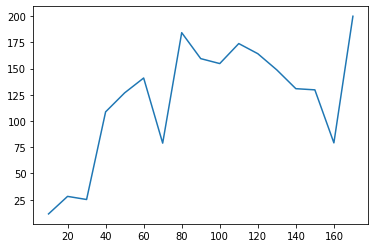

In [ ]:
be.clear_session()
tf.compat.v1.reset_default_graph()
seed(7)
tf.compat.v1.set_random_seed(7)

pms = Parameters()
pms.check_buffer = True
pms.init_buffer_size = 1000
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

As can be seen the initial buffer size plays role in reaching higher reward quickly, but then convergence is not something controlled by it and neither is stability.

In this case ,the idea intuitively is that the the model should approach the average reward value of 195 in evaluation over 100 episodes ( therefore the graph should be **trending upward**) and the **noise while trending upward should become smaller and smaller**

In [7]:
# In this run we  explore how buffersize, epsilon ( exploration -> exploitation) and synchorinization of Online-network (cont) and
# target network ( frozen) effect the convergence
buff_size = [5000, 10000]
initial_buff = [None]
eps = [0.5, 0.8]
sync_C = [100, 50, 500]

# creating all combination of params
from itertools import product
list_ = list(product(buff_size, initial_buff,eps, sync_C))

In [ ]:
# list to store the param config
param_dict =  []

# list to store the sequence of (episode, return) for each param config.
history = []

# storing the eval in the end.
param_eval = []

for val in list_:
  # clear and reset the tensorflow graph and clear the session
  be.clear_session()
  tf.compat.v1.reset_default_graph()

# setting random seed ( however given due to nature of problem and Deep network the result will not be reproducible exactly)
  seed(7)
  tf.compat.v1.set_random_seed(7)

  pms = Parameters()

  # updating buffer size
  pms.buf_size = val[0]

  # parameter to tell if need to initialize buffer with batch size or soem other other value
  pms.init_buffer_size = val[1]

  # updating the epsilon value
  pms.eps = val[2]

  # updating the synchronization frequency
  pms.C = val[3]

  print("training with parmas:",vars(pms))
  param_dict.append(vars(pms))
  dqn = Dqn(pms)
  ep_ids, returns = dqn.train_function()
  history.append([ep_ids, returns])
  param_eval.append(dqn.evaluation())
  dqn.close()



training with parmas: {'buf_size': 5000, 'batch': 256, 'epoch': 5, 'max_ep': 500, 'eps': 0.5, 'gamma': 0.9, 'C': 100, 'train_freq': 1, 'eval_freq': 10, 'net': [(128, 'relu'), (128, 'relu'), (2, 'relu')], 'lr': 0.0001, 'opt': <Optimizer.ADAM: 1>, 'check_buffer': False, 'init_buffer_size': None}
Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 13.0
Episode Id: 20 Return during training: 11.0
Episode Id: 30 Return during training: 9.0
Episode Id: 40 Return during training: 11.0
Episode Id: 50 Return during training: 11.0
Episode Id: 60 Return during training: 10.0
Episode Id: 70 Return during training: 28.0
Episode Id: 80 Return during training: 60.0
Episode Id: 90 Return during training: 101.0
Episode Id: 100 Return during training: 135.0
Episode Id: 110 Return during training: 144.0
Episode Id: 120 Return during training: 141.0
Episode Id: 130 Return during training: 146.0
Episode Id: 140 Return during training: 200.0
Episode Id: 150 Return durin

In [ ]:
# lets save the results for future use in case, but for this
# we need to replace the opt with string value rather than object instance of optimizer

for i in range(len(param_dict)):
  param_dict[i]['opt'] = 'ADAM'

# saving history
with open('history.ob', 'wb') as hist:
    pickle.dump(history, hist )

# saving params list
with open('param_dict.ob', 'wb') as hist:
    pickle.dump(param_dict, hist )

# writing the data to Google drive
path = '/content/drive/MyDrive/DQN/'  # path to the folder in google drive where data is saved
with open(path + "history.ob", 'wb') as a, open(path + "param_dict.ob", 'wb') as b:
    pickle.dump(history, a) 
    pickle.dump(param_dict, b)

In [8]:
# importing data for plot
path = '/content/drive/MyDrive/DQN/'
with open(path + "history.ob", 'rb') as a, open(path + "param_dict.ob", 'rb') as b:
    history = pickle.load(a)   # loading training data
    param_dict = pickle.load(b)   # loading test data 

# data manipulation to get the dataframe using which we can plot for different param settings
df = {'episodes': ['Null'], 'returns':['Null']}
for x in history:
    df['episodes'].append(x[0])
    df['returns'].append(x[1])
df['episodes'] = df['episodes'][1:]
df['returns'] = df['returns'][1:]

temp = np.array(list_)
df = pd.DataFrame.from_dict(df)

df['sync_C'] = temp[:,3]
df['buff_size'] = temp[:,0]
df['eps'] =  temp[:,2]

In [14]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

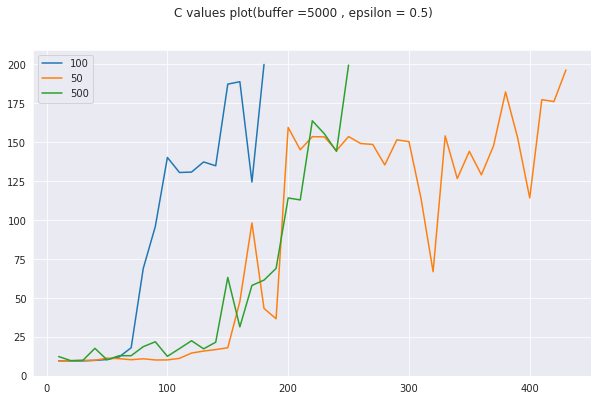

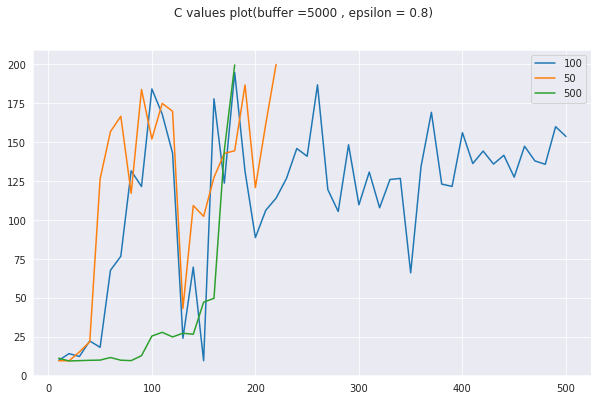

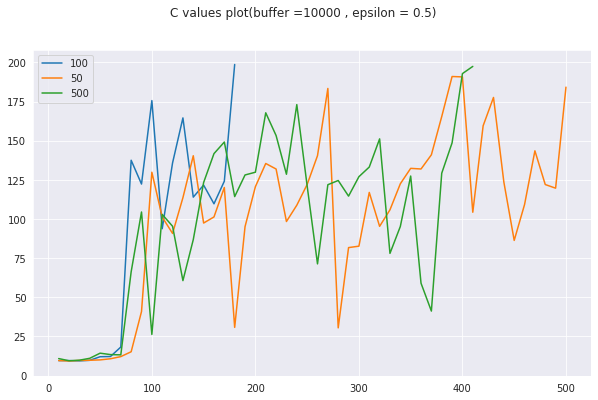

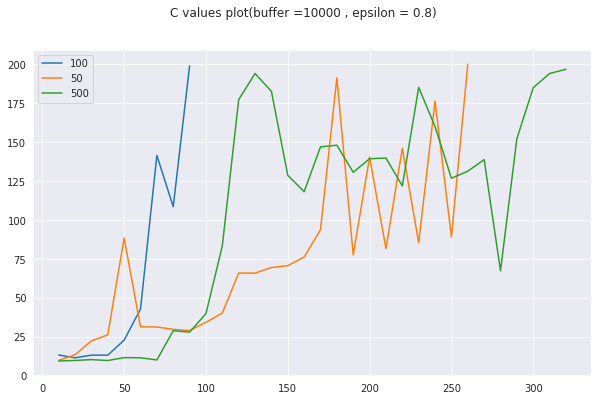

In [9]:

# keep all params fixed and just see (episode,return) sequence for different values of C( synchronization)
sns.set_style("darkgrid")
list_ = list(product(buff_size,eps))
for i in range(len(list_)):
  temp = df.loc[(df.buff_size == list_[i][0]) & (df.eps == list_[i][1])]
  plt.figure(figsize=(10,6))
  for x,y,z in zip(temp.episodes,temp.returns, temp.sync_C):
      plt.plot(x,y, label = z)
      plt.legend()
      plt.suptitle("C values plot(buffer ={} , epsilon = {})".format(list_[i][0], list_[i][1]))


Observations:
1. Low value of C takes time for task completion. Further low values of C cause the jitterness in the graph (noise/fluctuations). 
2. If higher the exploration then better to keep the synchorinization also higher.

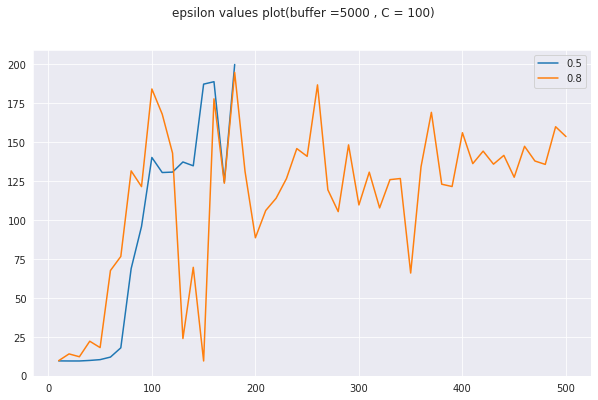

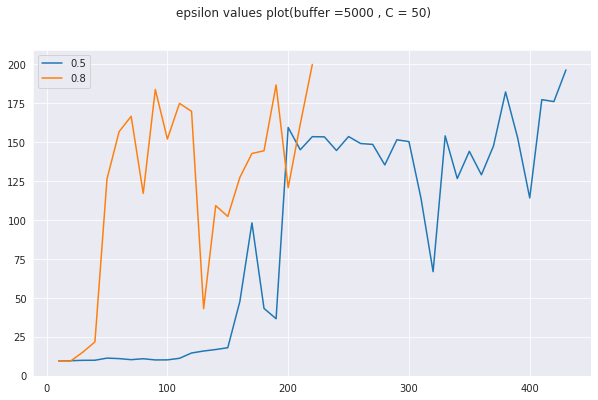

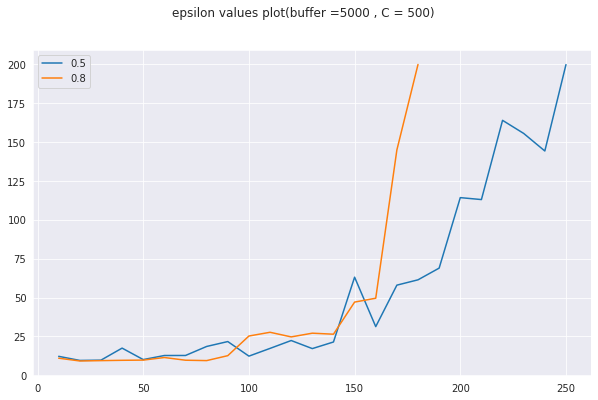

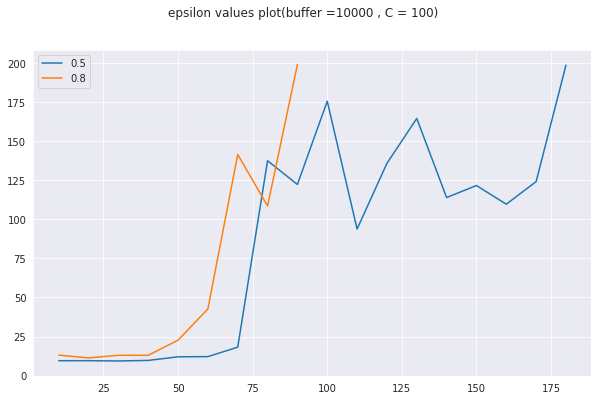

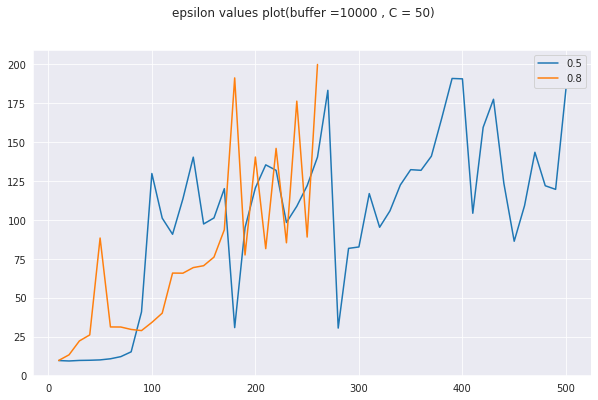

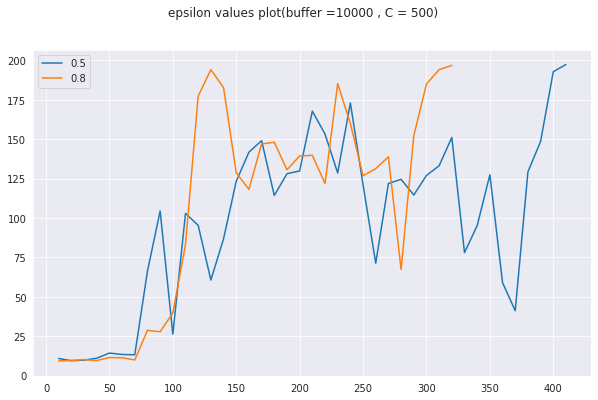

In [10]:
# keep all params fixed and just see (episode,return) sequence for different values of epsilon

sns.set_style("darkgrid")
list_ = list(product(buff_size,sync_C))
for i in range(len(list_)):
  temp = df.loc[(df.buff_size == list_[i][0]) & (df.sync_C == list_[i][1])]
  plt.figure(figsize=(10,6))
  for x,y,z in zip(temp.episodes,temp.returns, temp.eps):
      plt.plot(x,y, label = z)
      plt.legend()
      plt.suptitle("epsilon values plot(buffer ={} , C = {})".format(list_[i][0], list_[i][1]))

Observations:

1. Except for defalut paramaters in all case higher exploration leads to faster task completion, which initially seems counter intuitive. However if we look carefully then by doing high exploration in initial runs the model has not been forced to overestimate the values, which means if initially  the greedy action was to go left it still explored the right, and maybe later when right became the best action in state then network doesnt not need to update the weights significantly and could easily adapt to this and hence might be leaading to faster connvergence.

2. With high value of C for higher exploration the convergence is smooth( less noisy), which can be understood from fact that during exploration when Online - network is getting trained it is better to delay the update of target network to avoid frequenct update (Graph for buffer = 5000, c= 500 both epsilon value show smooth convergence). Though again buffer size and batch also might be playing some coupling effect(as explained below).



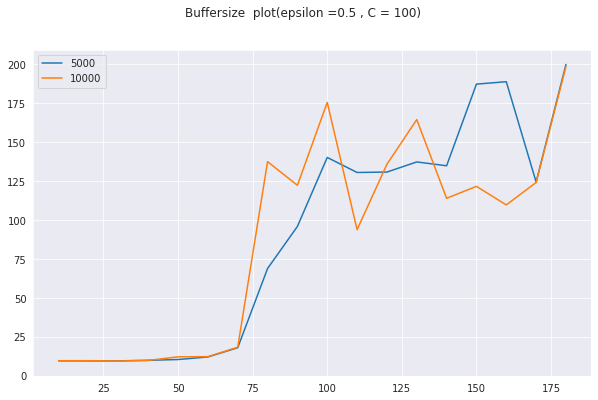

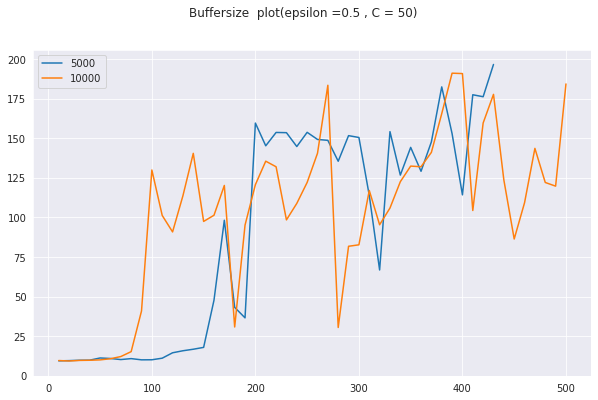

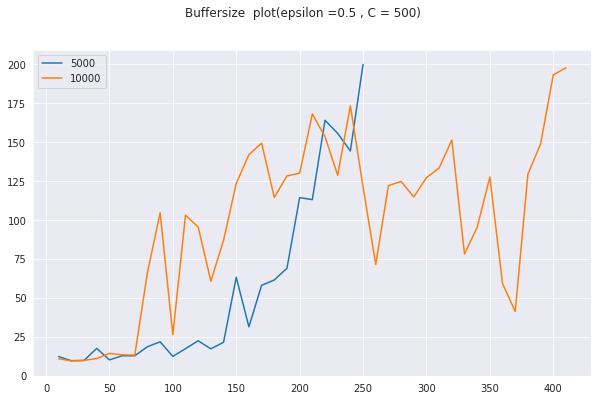

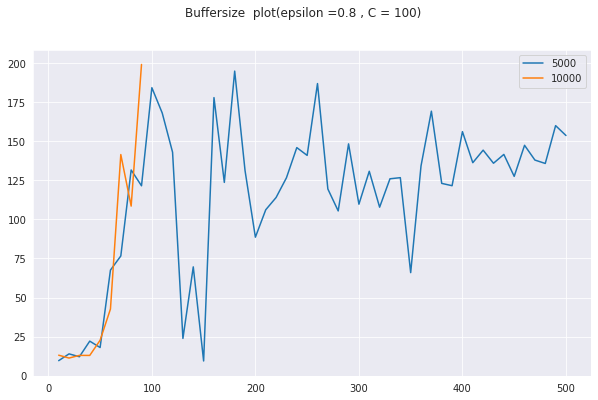

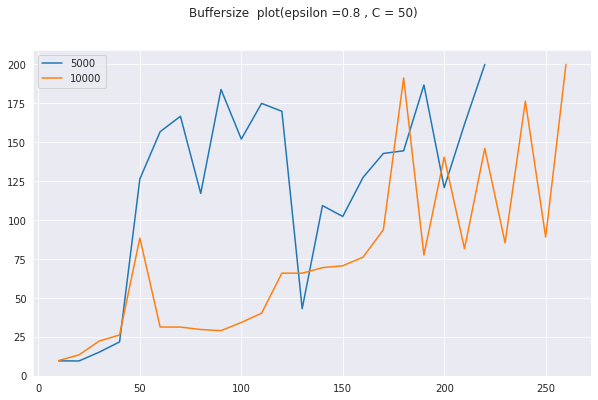

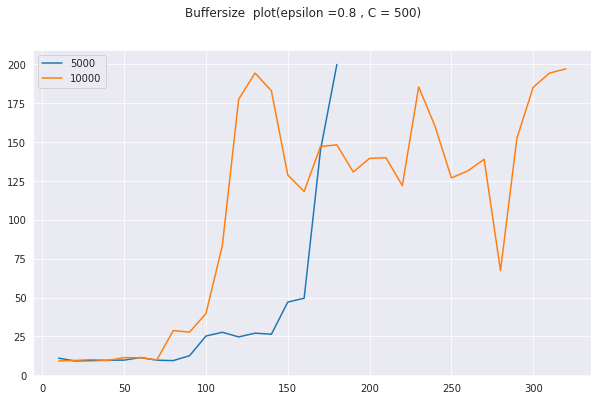

In [11]:
# keep all params fixed and just see (episode,return) sequence for different values of buffer

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
list_ = list(product(eps,sync_C))
for i in range(len(list_)):
  temp = df.loc[(df.eps == list_[i][0]) & (df.sync_C == list_[i][1])]
  plt.figure(figsize=(10,6))
  for x,y,z in zip(temp.episodes,temp.returns, temp.buff_size):
      plt.plot(x,y, label = z)
      plt.legend()
      plt.suptitle("Buffersize  plot(epsilon ={} , C = {})".format(list_[i][0], list_[i][1]))

Observation:
1. When buffer is increased the convergence becomes bumpy which is expected as there is lot of experiences to sample from. (In the model presented above this hints towards maybe to increase the batch size to average out the fluctuations or in the model presented in the last we can increase the batchsize to fetch more trianing data, and then use small mini_batch vlaue to make the learning stable ). 
2. Further it is seen that buffer value and C value and epsilon are very closely interlinked. Graph 1. Buffer doesnt matter a lot for epsilon = 0.5 and C= 100, however for epsilon = 0.5, higher value of C= 500 is favoured for buffer of 5000 in graph 3 and epsilon = 0.8, c= 500 for buffer of 5000 in graph 6 (fast and smooth convergence)
3. In a concluding manner it can be said that buffer cannot be increased or decreased in standalone manner it need to tuned in tandem with epsilon and C value.

In [ ]:
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

        # param to check if to print buffer or not
        self.check_buffer = False
        # param to initialize the buffer with these number of experiences,
        # if None then buffer gets initialized with batch size
        self.init_buffer_size = None

In [8]:
# exploring the effect of optimizers, learning rate and batch_size

lr = [0.0001, 0.001]
opt = [Optimizer.RMSPROP, Optimizer.SGD]
batch_size = [64,256]

from itertools import product
list_ = list(product(lr, opt,batch_size))

In [ ]:
# list to store the param config
param_dict =  []

# list to store the sequence of (episode, return) for each param config.
history = []

# storing the eval in the end.
param_eval = []

for val in list_:
  be.clear_session()
  tf.compat.v1.reset_default_graph()

  from numpy.random import seed
  seed(7)
  tf.compat.v1.set_random_seed(7)

  pms = Parameters()
  pms.lr = val[0]  
  pms.opt = val[1]
  pms.batch = val[2]
  pms.C = 500

  # as batch size of 64 is also involved to insure we have intial buffer of ample size, forcing buffer
  # initialization to size 500 to start with.
  pms.init_buffer_size = 500
  print("training with parmas:",vars(pms))
  param_dict.append(vars(pms))
  dqn = Dqn(pms)
  ep_ids, returns = dqn.train_function()
  history.append([ep_ids, returns])
  param_eval.append(dqn.evaluation())
  dqn.close()



training with parmas: {'buf_size': 5000, 'batch': 64, 'epoch': 5, 'max_ep': 500, 'eps': 0.5, 'gamma': 0.9, 'C': 500, 'train_freq': 1, 'eval_freq': 10, 'net': [(128, 'relu'), (128, 'relu'), (2, 'relu')], 'lr': 0.0001, 'opt': <Optimizer.RMSPROP: 2>, 'check_buffer': False, 'init_buffer_size': 500}
Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 12.0
Episode Id: 20 Return during training: 11.0
Episode Id: 30 Return during training: 10.0
Episode Id: 40 Return during training: 10.0
Episode Id: 50 Return during training: 10.0
Episode Id: 60 Return during training: 9.0
Episode Id: 70 Return during training: 12.0
Episode Id: 80 Return during training: 16.0
Episode Id: 90 Return during training: 15.0
Episode Id: 100 Return during training: 11.0
Episode Id: 110 Return during training: 13.0
Episode Id: 120 Return during training: 10.0
Episode Id: 130 Return during training: 10.0
Episode Id: 140 Return during training: 14.0
Episode Id: 150 Return during tra

In [ ]:
# removing the name of optmizer instance and keeping name of optmizer to save the output.
for i in [0,1,4,5]:
  param_dict[i]['opt'] = 'RMSProp'
for i in [2,3,6,7]:
  param_dict[i]['opt'] = 'SGD' 


path = '/content/drive/MyDrive/DQN/'  # path to the folder in google drive where data is saved
with open(path + "history_1.ob", 'wb') as a, open(path + "param_dict_1.ob", 'wb') as b:
    pickle.dump(history, a) 
    pickle.dump(param_dict, b)

In [9]:
# importing data for plot
import pickle

path = '/content/drive/MyDrive/DQN/'
with open(path + "history_1.ob", 'rb') as a, open(path + "param_dict_1.ob", 'rb') as b:
    history = pickle.load(a)   # loading training data
    param_dict = pickle.load(b)   # loading test data 

# data manipulation to get the dataframe using which we can plot for different param settings
df = {'episodes': ['Null'], 'returns':['Null']}
for x in history:
    df['episodes'].append(x[0])
    df['returns'].append(x[1])
df['episodes'] = df['episodes'][1:]
df['returns'] = df['returns'][1:]

temp = np.array(list_)
for i in [0,1,4,5]:
  temp[i][1] = 'RMSProp'
for i in [2,3,6,7]:
  temp[i][1] = 'SGD'

df = pd.DataFrame.from_dict(df)

df['batch_size'] = temp[:,2]
df['lr'] = temp[:,0]
df['optimizer'] =  temp[:,1]
df

,episodes,returns,batch_size,lr,optimizer
0,"[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,...","[10.79, 10.58, 9.58, 9.4, 11.37, 10.14, 9.86, ...",64,0.0001,RMSProp
1,"[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,...","[9.51, 9.76, 9.73, 9.43, 10.57, 9.52, 9.72, 11...",256,0.0001,RMSProp
2,"[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,...","[9.54, 9.57, 9.35, 9.38, 9.44, 9.6, 9.41, 9.55...",64,0.0001,SGD
3,"[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,...","[9.43, 9.49, 9.65, 9.47, 9.38, 9.46, 9.52, 9.5...",256,0.0001,SGD
4,"[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,...","[24.32, 10.54, 9.36, 9.64, 13.27, 17.37, 9.58,...",64,0.001,RMSProp
5,"[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,...","[9.46, 9.35, 9.22, 9.1, 10.92, 9.99, 10.97, 10...",256,0.001,RMSProp
6,"[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,...","[9.68, 9.64, 20.05, 9.66, 9.49, 9.31, 9.41, 9....",64,0.001,SGD
7,"[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,...","[9.52, 9.54, 18.1, 9.58, 19.93, 9.5, 9.61, 9.5...",256,0.001,SGD


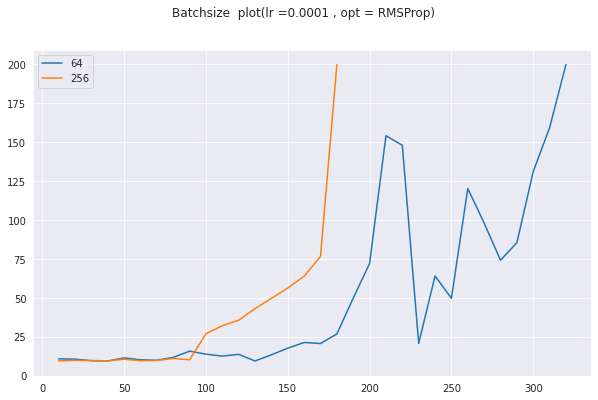

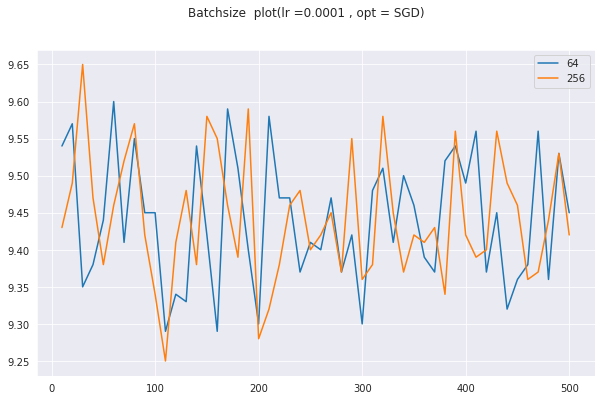

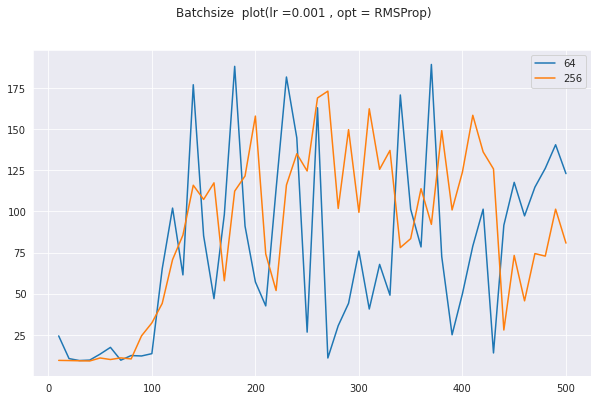

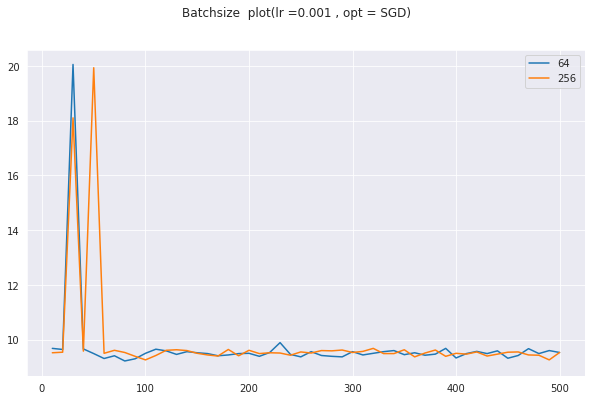

In [10]:
# keep all params fixed and just see (episode,return) sequence for different values of batch size

lr = [0.0001, 0.001]
opt = ['RMSProp','SGD']
batch_size = [64,256]


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
list_ = list(product(lr,opt))
for i in range(len(list_)):
  temp = df.loc[(df.lr == list_[i][0]) & (df.optimizer == list_[i][1])]
  plt.figure(figsize=(10,6))
  for x,y,z in zip(temp.episodes,temp.returns, temp.batch_size):
      plt.plot(x,y, label = z)
      plt.legend()
      plt.suptitle("Batchsize  plot(lr ={} , opt = {})".format(list_[i][0], list_[i][1]))

Obervations:
1. In the model presented above where the 'batch' variable is used to sample traning data from buffer, and same is used as batch_size during the training, Higher the batch size smoother the convergence ( due to averaging effect ) and also quick to converge, however higher learning rate can make this very jittery and slow converegnce.


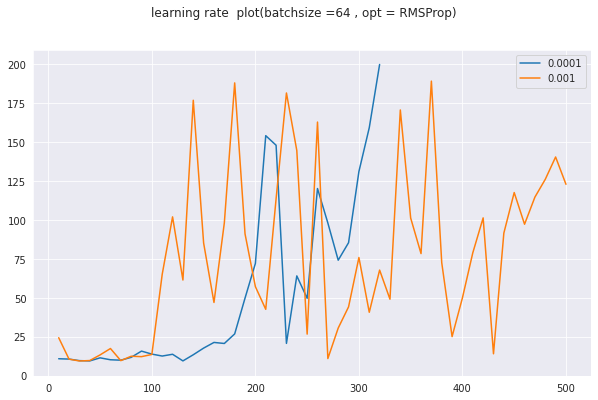

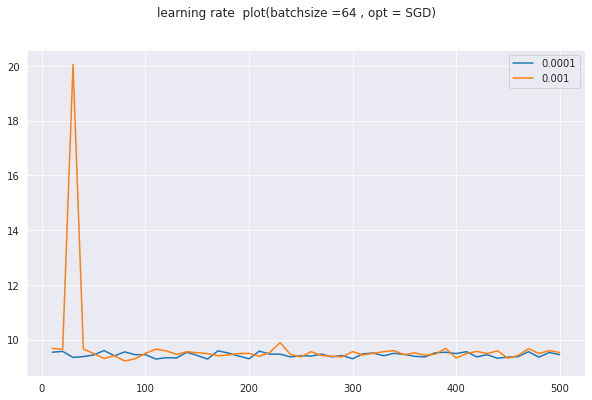

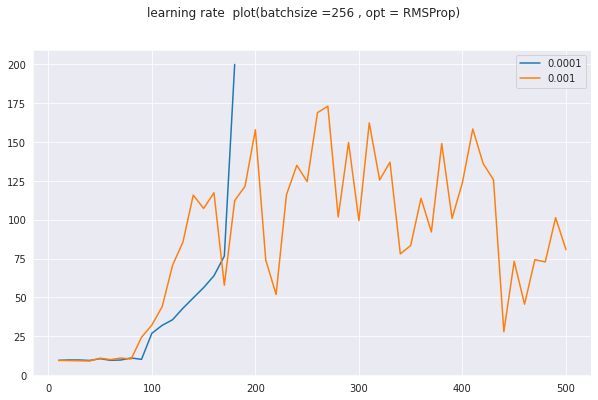

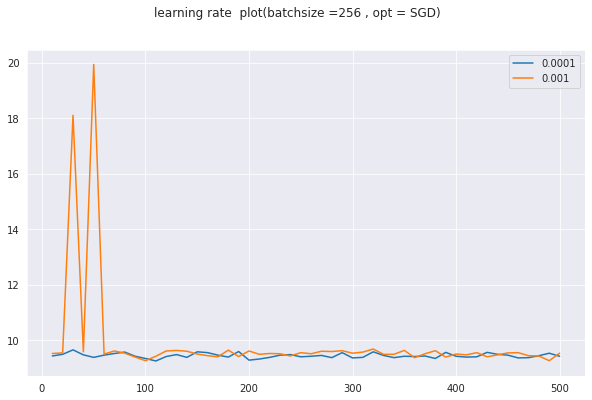

In [11]:
# keep all params fixed and just see (episode,return) sequence for different values of learning rate


sns.set_style("darkgrid")
list_ = list(product(batch_size,opt))
for i in range(len(list_)):
  temp = df.loc[(df.batch_size == list_[i][0]) & (df.optimizer == list_[i][1])]
  plt.figure(figsize=(10,6))
  for x,y,z in zip(temp.episodes,temp.returns, temp.lr):
      plt.plot(x,y, label = z)
      plt.legend()
      plt.suptitle("learning rate  plot(batchsize ={} , opt = {})".format(list_[i][0], list_[i][1]))

Obervation: As discussed above the lower learning rate make the convergence smooth and fast.

In case of SGD the convergence is not reached however in a trial it is seen that if we increase the max episodes to very high value then very rarely sometimes it does completes the task, but is not guaranteed. The reason could be SGD is not adaptive, further the model might be getting stuck in saddle point and it takes time before it can move out of this to find minima or just remain trapped in local minima.

training with parmas: {'buf_size': 5000, 'batch': 256, 'epoch': 5, 'max_ep': 5000, 'eps': 0.5, 'gamma': 0.9, 'C': 100, 'train_freq': 1, 'eval_freq': 10, 'net': [(128, 'relu'), (128, 'relu'), (2, 'relu')], 'lr': 0.0001, 'opt': <Optimizer.SGD: 3>, 'check_buffer': False, 'init_buffer_size': None}
Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 20.0
Episode Id: 20 Return during training: 10.0
Episode Id: 30 Return during training: 10.0
Episode Id: 40 Return during training: 10.0
Episode Id: 50 Return during training: 9.0
Episode Id: 60 Return during training: 10.0
Episode Id: 70 Return during training: 9.0
Episode Id: 80 Return during training: 10.0
Episode Id: 90 Return during training: 10.0
Episode Id: 100 Return during training: 11.0
Episode Id: 110 Return during training: 9.0
Episode Id: 120 Return during training: 9.0
Episode Id: 130 Return during training: 10.0
Episode Id: 140 Return during training: 10.0
Episode Id: 150 Return during trainin

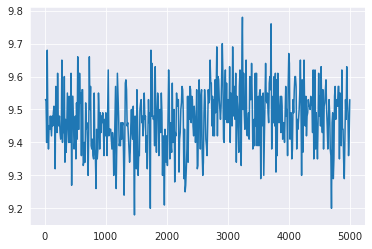

In [15]:

be.clear_session()
tf.compat.v1.reset_default_graph()

from numpy.random import seed
seed(7)
tf.compat.v1.set_random_seed(7)

pms = Parameters()
pms.opt = Optimizer.SGD
pms.max_ep = 5000

# as batch size of 64 is also involved to insure we have intial buffer of ample size, forcing buffer
# initialization to size 500 to start with.
print("training with parmas:",vars(pms))
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

### Exploring the Training frequency param

Lets understand what happens when we increase the train_freuency.
As we increase the train frequency, under the hood the buffer will keep increasing intially and model is not getting trained, 
to compensate this we can increase the 'batch' to sample more experiences from buffer when the training is triggered. However in case of when buffer is full, then there are experiences which will get removed out very fast, to compensate this we can increase the buffer size and make model to explore more initally. With this intuition lets try to make change in paramaters discussed and compare the converegnce properties with default
params.



In [9]:
# list to store the param config
param_dict =  []

# list to store the sequence of (episode, return) for each param config.
history = []

# storing the eval in the end.
param_eval = []



##### Triggeer default params---------
be.clear_session()
tf.compat.v1.reset_default_graph()

from numpy.random import seed
seed(7)
tf.compat.v1.set_random_seed(7)

pms = Parameters()
print("training with parmas:",vars(pms))
param_dict.append(vars(pms))
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
history.append([ep_ids, returns])
dqn.close()

training with parmas: {'buf_size': 5000, 'batch': 256, 'epoch': 5, 'max_ep': 500, 'eps': 0.5, 'gamma': 0.9, 'C': 100, 'train_freq': 1, 'eval_freq': 10, 'net': [(128, 'relu'), (128, 'relu'), (2, 'relu')], 'lr': 0.0001, 'opt': <Optimizer.ADAM: 1>, 'check_buffer': False, 'init_buffer_size': None}
Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 17.0
Episode Id: 20 Return during training: 10.0
Episode Id: 30 Return during training: 9.0
Episode Id: 40 Return during training: 12.0
Episode Id: 50 Return during training: 11.0
Episode Id: 60 Return during training: 12.0
Episode Id: 70 Return during training: 11.0
Episode Id: 80 Return during training: 10.0
Episode Id: 90 Return during training: 30.0
Episode Id: 100 Return during training: 40.0
Episode Id: 110 Return during training: 27.0
Episode Id: 120 Return during training: 121.0
Episode Id: 130 Return during training: 84.0
Episode Id: 140 Return during training: 119.0
Episode Id: 150 Return during tr

In [10]:

be.clear_session()
tf.compat.v1.reset_default_graph()

from numpy.random import seed
seed(7)
tf.compat.v1.set_random_seed(7)

pms = Parameters()

# changing train_freq
pms.train_freq = 5
# as discussed above making changes to appropriate params

pms.batch = 256
pms.epoch = 20
pms.buf_size = 10000
pms.eps = 0.7

print("training with parmas:",vars(pms))
param_dict.append(vars(pms))
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
history.append([ep_ids, returns])
dqn.close()

training with parmas: {'buf_size': 10000, 'batch': 256, 'epoch': 20, 'max_ep': 500, 'eps': 0.7, 'gamma': 0.9, 'C': 100, 'train_freq': 5, 'eval_freq': 10, 'net': [(128, 'relu'), (128, 'relu'), (2, 'relu')], 'lr': 0.0001, 'opt': <Optimizer.ADAM: 1>, 'check_buffer': False, 'init_buffer_size': None}
Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 19.0
Episode Id: 20 Return during training: 11.0
Episode Id: 30 Return during training: 11.0
Episode Id: 40 Return during training: 10.0
Episode Id: 50 Return during training: 11.0
Episode Id: 60 Return during training: 29.0
Episode Id: 70 Return during training: 24.0
Episode Id: 80 Return during training: 44.0
Episode Id: 90 Return during training: 60.0
Episode Id: 100 Return during training: 84.0
Episode Id: 110 Return during training: 55.0
Episode Id: 120 Return during training: 29.0
Episode Id: 130 Return during training: 88.0
Episode Id: 140 Return during training: 58.0
Episode Id: 150 Return during t

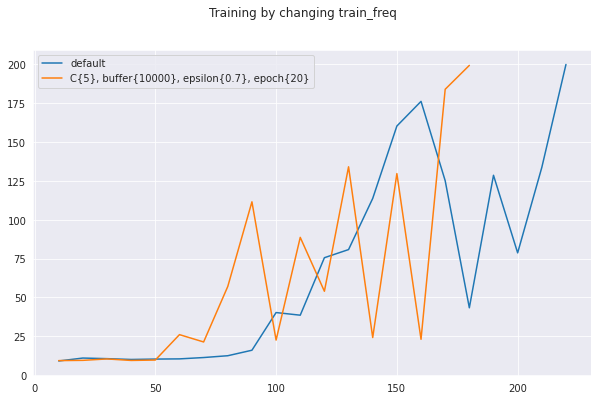

In [14]:
# data manipulation to get dataframe using which we can plot (episodes,return) sequence.

df = {'episodes': ['Null'], 'returns':['Null']}
for x in history:
    df['episodes'].append(x[0])
    df['returns'].append(x[1])
df['episodes'] = df['episodes'][1:]
df['returns'] = df['returns'][1:]
df = pd.DataFrame.from_dict(df)
labels = ['default', 'C{5}, buffer{10000}, epsilon{0.7}, epoch{20}']

plt.figure(figsize=(10,6))
for x,y,z in zip(df.episodes, df.returns,labels ):
    plt.plot(x,y, label = z)
    plt.legend()
    plt.suptitle("Training by changing train_freq")

### Changing the way of sampling and training:
The batch size determines how large the update could be for weights therefore, to mkae leanring stable we can use batch size of arnd 15-128 to give better stability.To make this happen we will use the self.batch to sample the number of experiences from buffer and then use one more parameter self.mini_batch to train network with this batch size over self.epochs. There are two sets of results 
1. Original default parameters provided without mini_btach parameter. ( 10 trials)
2. default params with mini_batch  param included (5 trials)

In [ ]:
history = []
param_dict = []

# Defualt params config
for i in range(10):
  be.clear_session()
  tf.compat.v1.reset_default_graph()

  from numpy.random import seed
  seed(7)
  tf.compat.v1.set_random_seed(7)
  pms = Parameters()
  param_dict.append('Default')
  dqn = Dqn(pms)
  ep_ids, returns = dqn.train_function()
  history.append([ep_ids, returns])
  dqn.evaluation(video=False)
  dqn.close()

In [ ]:

path = '/content/drive/MyDrive/DQN/'  # path to the folder in google drive where data is saved
with open(path + "history_2.ob", 'wb') as a, open(path + "param_dict_2.ob", 'wb') as b:
    pickle.dump(history, a) 
    pickle.dump(param_dict, b)

In [25]:
# importing data for plot
import pickle

path = '/content/drive/MyDrive/DQN/'
with open(path + "history_2.ob", 'rb') as a, open(path + "param_dict_2.ob", 'rb') as b:
    history = pickle.load(a)   # loading training data
    param_dict = pickle.load(b)   # loading test data 

# data manipulation to get the dataframe using which we can plot for different param settings
df = {'episodes': ['Null'], 'returns':['Null']}
for x in history:
    df['episodes'].append(x[0])
    df['returns'].append(x[1])
df['episodes'] = df['episodes'][1:]
df['returns'] = df['returns'][1:]

df = pd.DataFrame.from_dict(df)


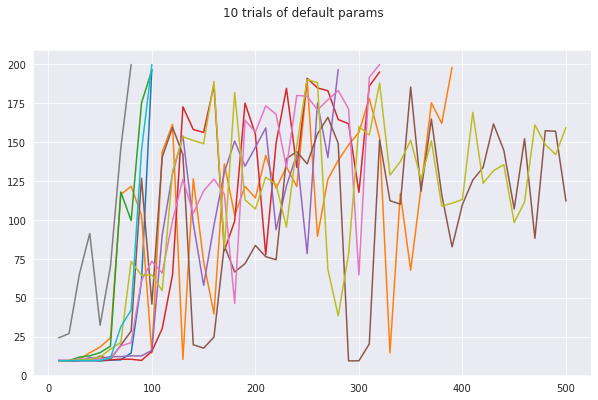

In [26]:
plt.figure(figsize=(10,6))
for x,y in zip(df.episodes, df.returns):
    plt.plot(x,y)
    plt.suptitle("10 trials of default params")

As can be seen the convergence is not smooth always and there are some trials which do not solve the task in limit of 500 episodes. So we can say convergence is not always guaranted with the limit scope of episodes, but surely it cna be tuned in a way to make sure that it solves the task as all the graphs are genrally upward trending, but have huge jitterness( fluctuations)

below is implementation with mini_batch param.

In [21]:
# The implementation of DQN.
class Dqn:

    
    def __init__(self, params):         
        self.env = None                       # The environment where the RL agent will learn.
        self.buffer_size = params.buf_size    # The maximum size of the experience replay.
        self.batch_size = params.batch        # Batch size during training.
        self.epoch = params.epoch             # For one training cycle, the number epoch on a batch.
        self.max_episode = params.max_ep      # The number of episodes for training.
        self.eps0 = params.eps                # The starting value of epsilon in the epsilon-greedy policy.
        self.gamma = params.gamma             # Discounting factor.
        self.C = params.C                     # Frequency of synchronizing the frozen network.
        self.train_freq = params.train_freq   # Update frequency for the not frozen network.
        self.eval_freq = params.eval_freq     # Evaluation frequency.
        self.net = params.net                 # The description of the network. List of tuples. A tuple: (number of units, activation)
        self.lr = params.lr                   # learning rate
        self.opt = params.opt                 # Optimizer.

        self.q_cont, self.q_frzn = None, None # two networks for training: continuously updated and frozen

        self.buffer = []  # experience replay
    
        self.env = gym.make('CartPole-v0')
        self.env.reset()
        self.q_cont, self.q_frzn = self._init_models()

        #----------------------------------Added parameter----------
        # param to check if to print buffer or not
        self.check_buffer = params.check_buffer
        # # param to initialize the buffer with these number of experiences,
        # if None then buffer gets initialized with batch size
        self.init_buffer_size = params.init_buffer_size
        # mini batch during training
        self.mini_batch = params.mini_batch
    
    # ------------------------------------------------------
    # functions for initialization
    
    def _init_optimizer(self):

        optz = None
        if self.opt == Optimizer.ADAM:
            optz = Adam(self.lr)
        elif self.opt == Optimizer.SGD:
            optz = SGD(self.lr)
        elif self.opt == Optimizer.RMSPROP:
            optz = RMSprop(self.lr)

        return optz

    # The network builds up from Dense layers (similar to the fully connected)
    def _init_models(self):
        
        def build(strc):
            # strc - list of tuples
            # each tuple contains: number of nodes in the dense layer, activation function name (e.g.: 'relu')

            q = Sequential() 

            # NOTE 1. The input shape = (4,) is for the dimension of state space which has four variables as discussed above, alternatively 
            # there could be image (box) as the input also in which case there is practice to stack few frames (ex 4 frames) 
            # whereby then Conv2D filter can be applied to allow the netowrk to extract the feature on its own, rather than hand-crafting
            # features.
          
            q.add(Dense(strc[0][0], activation=strc[0][1], input_shape=(4,)))
            
            # adding the the remaining dense layers to the model.
            for i in range(1, len(strc)):
                q.add(Dense(strc[i][0], activation= strc[i][1]))

            optz = self._init_optimizer()
            q.compile(optimizer=optz, loss = 'mse')

            return q

        q_cont = build(self.net)  # continuously updated network (Q-function)
        q_frzn = build(self.net)  # frozen network (target)

        q_cont.set_weights(q_frzn.get_weights())  # initial synchronization

        return q_cont, q_frzn

    def _init_buffer(self, number):
        # gathers 'number' pieces of experiences randomly
        exps = []
        obs, rw, done, _ = self.env.step(0)
        
        for _ in range(number):

            if done:
                obs = self.env.reset()

            action = self.env.action_space.sample()  # sampling random actions from the environment
            obs_next, rw, done, _ = self.env.step(action)  # taking the step and observe the results
            exps.append((obs, rw, action, done, obs_next))  # we append a new experience
            obs = obs_next

        self.append(exps)  # you will implement this function
    
    def close(self):
        self.env.close()

    def train_function(self):
        
        # initializing experience replay with random experiences
        # this is implemented if we want ot initialize the buffer with 
        # number of experiences other than batch size
        if not self.init_buffer_size:
          self._init_buffer(self.batch_size)
        else:
          self._init_buffer(self.init_buffer_size)

        print("Initialization was finished.")
        print("Training was started.")
        train_t = 1
        ep_id = 1
        cntr = 0
        eval_permitted = True
        rtn = 0
        exps = []
        
        ep_ids = []
        returns = []

        eps = self.eps0
        self.env.reset()

        # initialization
        obs, _, done, _ = self.env.step(0)
        
        # check condition for max_episodes to run during training
        while ep_id < self.max_episode:

            # print("cache experience replay size",len(exps))
            # print("Counter",cntr,'\n', "Return", rtn)

            # Note 2.
            # Each episode has a sequence of (state,action,reward,nextstate), counter
            # keeps the track of same. We will use the same to trigger the training and 
            # appending the set of experiences collected (cachce) to the buffer (experience replay buffer). 
            cntr += 1
            
            # Note 4. check condition to see if we need to reset the environment, update the episode id and reset rtn = 0.
            if done:
                # print("episode id", ep_id, " & Return is", rtn)

                if ep_id % 10 == 0:
                    print('Episode Id: ' + str(ep_id) + ' Return during training: ' + str(rtn))
                rtn = 0
                ep_id += 1
                eval_permitted = True
                obs = self.env.reset() # when an episode ends (done = True) the environment is reseted

            # Note 5.we select next action with epsilon greedy approach using q_cont (in select_action_epsilon function)
            action = self.select_action_epsilon(obs, eps)  # ---- select the next action with epsilon greedy -----

            obs_next, rw, done, _ = self.env.step(action)  # ----- take a new step with the environment -----
            rtn += rw
            
            # Note 3.
            # If the experience leads to termination then it could be either we failed ( angle > 15, x > 2.4, x< -2.4 etc)
            # or we succesfully completed the game. In each case we do the credit assignment. if return > 180 then its good else bad and
            # therefore we appropriately update reward.
            if done:
                # print("Termination condition")
                if rtn < 180:
                    # print("bad", rtn)
                    rw = -1
                    obs_next *= 0.0
                    obs *= 0.0
                elif rtn >= 180:
                    # print("Good", rtn)
                    rw = 100

            exps.append((obs, rw, action, done, obs_next))
            obs = obs_next

            # Note 6. This is to append the experiences cache to buffer (expereince replay), and clear the cache of 
            # experiences set
            if cntr % 128 == 0:
                self.append(exps)
                exps.clear()
            
            # training
            # Condition to check if to trigger the training or not as defualt train_freq is '1', therefore for each iteration (counter) the training is triggered.
            if  cntr % self.train_freq == 0:
                # TO MAKE THE TRAINING MORE STABLE THE BATCH_SIZE is used to get data, then its broken into further mini_batch and trianed over epochs = self.epoch
                a,b = self.sample(self.batch_size)
                self.q_cont.fit(a,b,batch_size = self.mini_batch, epochs = self.epoch, verbose = False)

                # # print('Trianing',train_t)
                # train_t += 1

                # Note 7. for how the x(=a) and y (=b) are being processed we will need to look at sample function.( provided below) ##########################
                # a,b = self.sample(self.batch_size)
                
                # Note 8. Q_cont is online Q-network which is trained regularly
                # self.q_cont.fit(a,b,batch_size = self.batch_size, epochs = self.epoch, verbose = False)
                # ----- sample experiences from the replay then train q_cont with them
            
            # synchronizing the frozen network
            if cntr % self.C == 0:
                self.q_frzn.set_weights(self.q_cont.get_weights())

            # evaluating at the current stage of learning
            if ep_id % self.eval_freq == 0 and eval_permitted:

                # Note 9. r is mean return over 100 episodes (evaluation function had 50 episodes, but updated to 100 as per the problem description)
                r = self.evaluation()
                ep_ids.append(ep_id)
                returns.append(r)
                # reset the eval_permitted, this will become true again when, next episode is completed
                eval_permitted = False

                # Note 10. The problem is solved if average reward is 195 gathered in 100 episodes, 
                # https://github.com/openai/gym/wiki/Leaderboard#cartpole-v0
                # however this value was hardcoded here to 185 and episode limit in evaluation function to 50, which had been updated according to problem. 
                # So in this case problem is solved if average reward is 195 gathered in 100 episodes
                if r >= 195:
                    break
            
            # Decreasing the epsilon value for epsilon-greedy. Exploration -> exploitation
            eps = max(eps - 0.001, 0.01)

        print("Training was finished.")
        return ep_ids, returns

    def evaluation(self, video=False):
        
        orig_env = self.env
        if video:
            self.env = Monitor(orig_env, 'videos/cartpole', force=True)

        obs = self.env.reset()
        done = False
        rtn = 0
        ep_id = 0
        rtns = []
        
        # Note. 11. updating the loop to account for 100 episodes
        while ep_id < 100:

            if done:
                rtns.append(rtn)
                rtn = 0
                ep_id += 1
                obs = self.env.reset()

            # As this is evaluation we can use epsilon-greedy with epsilon = 0.01
            action = self.select_action_epsilon(obs, 0.01)
            obs, rw, done, _ = self.env.step(action)
            rtn += rw

        self.env = orig_env
        return np.mean(rtns)

    # ------------------------------------------------------
    # Functions for handling the experience replay

    def clear_buffer(self):
        self.buffer.clear()

    # The new experiences are added at the end of the buffer.
    # The too old experiences are deleted.
    def append(self, experiences):
        check = self.check_buffer
        # experiences - list of experiences
        
        # ----- checking if appending the new set of experiences to the buffer has enough space -----
        if check:
          print("Buffer size is: ", len(self.buffer))
      

        if self.buffer_size - len(self.buffer) < len(experiences) :

            # deleting enteries in buffer from front (first in first out) for adding new experiences
            self.buffer = self.buffer[len(experiences)- (self.buffer_size - len(self.buffer)):]
            

        self.buffer += experiences  # finally we append the new experiences to the buffer

    def sample(self, number):
        exps = random.sample(self.buffer, number)    # experiences list
        obs = np.stack([x[0] for x in exps], axis=0) # numpy array is used by keras, for creating a batch observations should be stacked
        rws = np.stack([x[1] for x in exps], axis=0) # ----- do similar stacking for the rewards -----
        acts = np.stack([x[2] for x in exps], axis=0) # stacking of actions
        dones = np.stack([x[3] for x in exps], axis=0) # stacking of done (boolean)
        next_obs = np.stack([x[4] for x in exps], axis=0) # stacking of next state


        q_vals = self.q_cont.predict(obs) # ----- predict (forward execute) with q_cont on obs -----   # q_vals size should be: (batch_size, 2)
        fzn_q_vals = self.q_frzn.predict(next_obs) # ----- predict with q_frzn on next_obs -----
        
        # print("Q-values and Frozen Q-val",q_vals, fzn_q_vals)
        # The action function is represented by a network.
        # The input of this network is the state, 
        # the output is the set of action-values
        # corresponding to the actions.
        # So the number of outputs is equal with the nunmber of actions.
        # In training we sample one transition at a time, therefore we have loss
        # for only one output (action) at a time.
        # But for training, we have to provide information for all of the outputs.
        # How can we solve this?

        # Note 12.
        # As explained above since q_cont has been used for action we use the q_frzn for q-val estimation
        # further (1-dones) is incorporated to factor in terminal condition
        sub_values = rws + self.gamma * (1 - dones) * np.max(fzn_q_vals, axis=1) # ----- calculate this according to the one-step return for Q-learning -----
        # print("list",list(range(number)),"actions", acts)
        # print(q_vals[list(range(number)),acts] )
        # creating the list of target values for network
        q_vals[list(range(number)), acts] = sub_values  # this will be the target during training

        x = obs.astype(dtype=np.float32)
        y = q_vals.astype(dtype=np.float32)
        
        return x, y

    # ------------------------------------------------------
    # Choosing an action

    # epsilon-greedy
    def select_action_epsilon(self, state, eps):  # state shape: (4) nunmpy array
        s = np.expand_dims(state, axis=0)
        max_idx = np.argmax(self.q_cont.predict(s, batch_size=1))
        if np.random.random() < 1 - eps:
            return max_idx
        return (max_idx + 1) % 2 # now we have only two actions

    # no epsilon-greedy
    def select_action(self, state):
        s = np.expand_dims(state, axis=0)
        return np.argmax(self.q_cont.predict(s, batch_size=1))

In [22]:
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM
# ----------Newly added params---------
        # param to check if to print buffer or not
        self.check_buffer = False
        # param to initialize the buffer with these number of experiences,
        # if None then buffer gets initialized with batch size
        self.init_buffer_size = None

        self.mini_batch = 32

Checking for convergence over 10 trails. As discussed earlier the focus will be to check if:
1. there is some natural upper bound on iterations to guarantee the completion of task,
2. how stable the convergence is terms of fluctuations as episodes increase (jitterness),
3. and the graph overall trending pattern

In [23]:
history = []
param_dict = []

# Defualt params config
for i in range(5):
  be.clear_session()
  tf.compat.v1.reset_default_graph()

  from numpy.random import seed
  seed(7)
  tf.compat.v1.set_random_seed(7)
  pms = Parameters()
  param_dict.append('Default')
  dqn = Dqn(pms)
  ep_ids, returns = dqn.train_function()
  history.append([ep_ids, returns])
  dqn.evaluation(video=False)
  dqn.close()

Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 13.0
Episode Id: 20 Return during training: 26.0
Episode Id: 30 Return during training: 107.0
Episode Id: 40 Return during training: 133.0
Episode Id: 50 Return during training: 142.0
Episode Id: 60 Return during training: 126.0
Episode Id: 70 Return during training: 157.0
Episode Id: 80 Return during training: 96.0
Episode Id: 90 Return during training: 151.0
Episode Id: 100 Return during training: 82.0
Episode Id: 110 Return during training: 200.0
Training was finished.
Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 17.0
Episode Id: 20 Return during training: 10.0
Episode Id: 30 Return during training: 51.0
Episode Id: 40 Return during training: 68.0
Episode Id: 50 Return during training: 138.0
Episode Id: 60 Return during training: 138.0
Episode Id: 70 Return during training: 75.0
Episode Id: 80 Return during training: 200.0
Episode Id: 90 Return durin

KeyboardInterrupt: ignored

In [24]:
path = '/content/drive/MyDrive/DQN/'  # path to the folder in google drive where data is saved
with open(path + "history_3.ob", 'wb') as a, open(path + "param_dict_3.ob", 'wb') as b:
    pickle.dump(history, a) 
    pickle.dump(param_dict, b)

In [27]:
# importing data for plot
import pickle

path = '/content/drive/MyDrive/DQN/'
with open(path + "history_3.ob", 'rb') as a, open(path + "param_dict_3.ob", 'rb') as b:
    history = pickle.load(a)   # loading training data
    param_dict = pickle.load(b)   # loading test data 

# data manipulation to get the dataframe using which we can plot for different param settings
df = {'episodes': ['Null'], 'returns':['Null']}
for x in history:
    df['episodes'].append(x[0])
    df['returns'].append(x[1])
df['episodes'] = df['episodes'][1:]
df['returns'] = df['returns'][1:]

df = pd.DataFrame.from_dict(df)

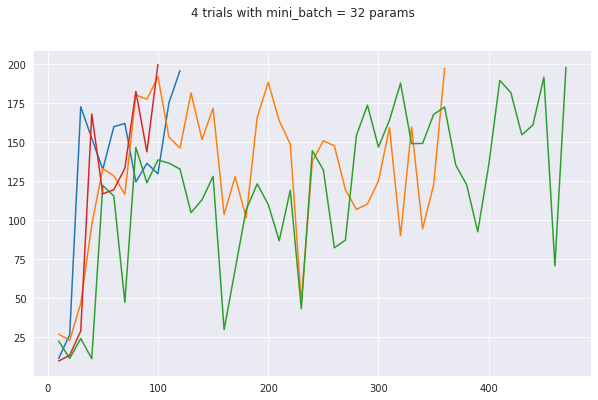

In [29]:
plt.figure(figsize=(10,6))
for x,y in zip(df.episodes, df.returns):
    plt.plot(x,y)
    plt.suptitle("4 trials with mini_batch = 32 params")

As can be seen this also not solves the jitterness in the convergence though of 4 trails all solved the task.